# 1. Importing Required Libraries
### We begin by importing the libraries listed below:
### (i) TensorFlow is an open-source framework for developing, training, and deploying machine learning models.

### (ii) Keras is an open-source framework for building neural network designs that can operate on both CPUs and GPUs.

### (iii) Matplotlib is a Python visualisation package for displaying interactive charts and pictures.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

# 2. Downloading Dataset - CIFAR 10 
### Through its dataset module, the deep learning Keras library gives relatively easy access to the CIFAR10 dataset.

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

## Referring the class names to the images

In [3]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Partitioning the dataset for the validation data 
### By default, the CIFAR dataset is divided into 50,000 training data and 10,000 test data. The validation data is the final split of the dataset that we require.

In [4]:
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[:5000], train_labels[:5000]

In [5]:
#It takes the train, test, and validation dataset partitions and returns a corresponding TensorFlow Dataset representation.
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

# 3. Pre-Processing

### Preprocessing is usually done to verify that the data used is in the correct format.
### We present the pixel information from five training photos into real images using the Matplotlib package. There is also an indicator of the class to which each image's represented material belongs.

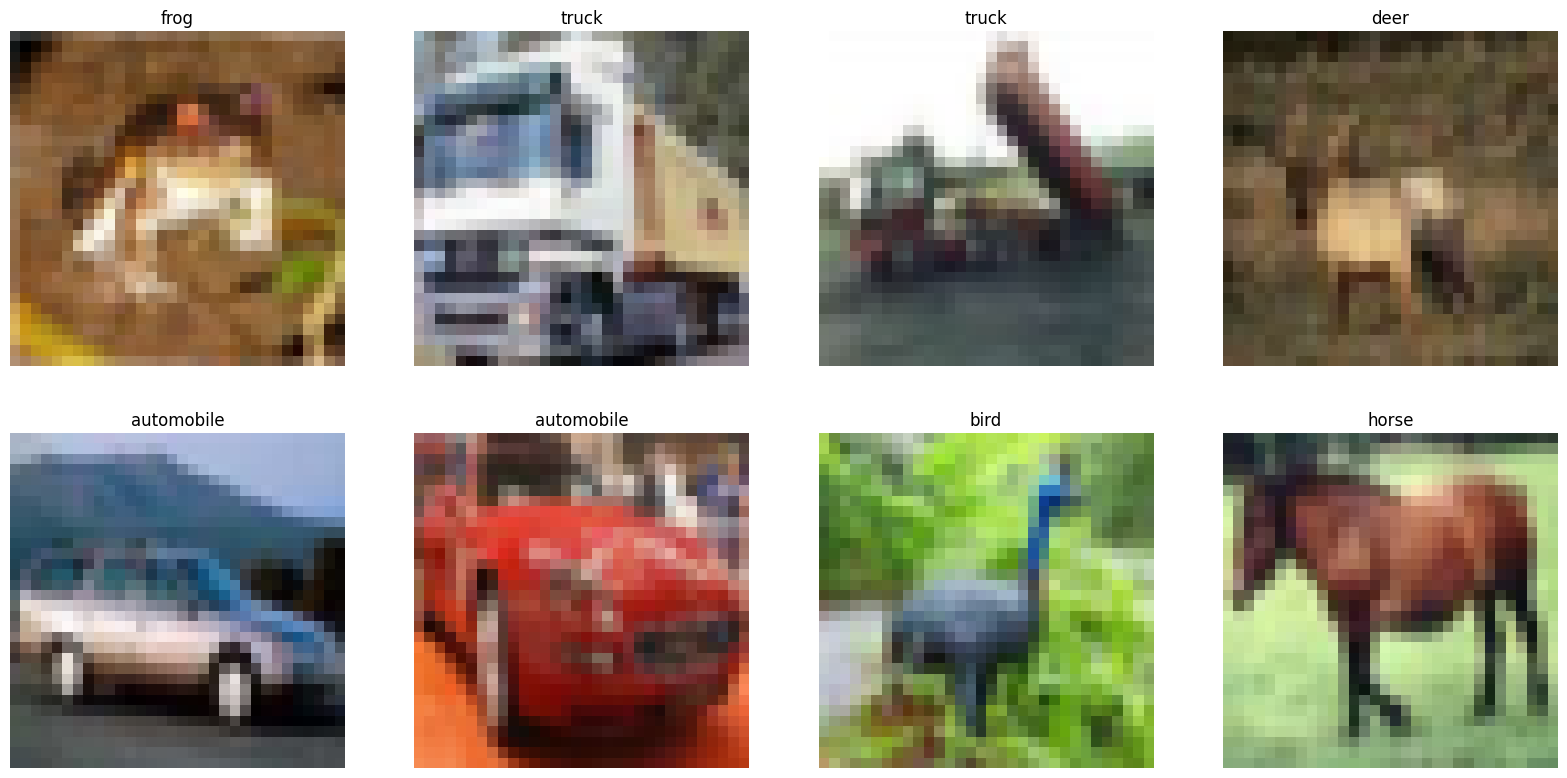

In [6]:
plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(train_ds.take(8)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

### A function named "process_images" will be made.

### This function will handle all of the data preparation that we need to do. The machine learning pipeline calls this function later on.

In [7]:
def process_images(image, label):
    #normalizing images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    
    #resizing images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

# 4. Data/Input Pipeline

### An input/data pipeline is defined as a collection of procedures or functions that are called one after the other in a certain order.

In [8]:
#size of each of the dataset partition we created

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 5000
Test data size: 10000
Validation data size: 5000


### Three primary operations:
### 1. Preprocessing the data within the dataset
### 2. Shuffle the dataset
### 3. Batch data within the dataset

In [9]:
train_ds = (train_ds.map(process_images).shuffle(buffer_size=train_ds_size).batch(batch_size=32, drop_remainder=True))

test_ds = (test_ds.map(process_images).shuffle(buffer_size=train_ds_size).batch(batch_size=32, drop_remainder=True))

validation_ds = (validation_ds.map(process_images).shuffle(buffer_size=train_ds_size).batch(batch_size=32, drop_remainder=True))

# 5. Model Implementation

In [10]:
#Keras implementation of the AlexNet CNN architecture.

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

# 6. Tensorboard

### A programme called TensorBoard offers a number of visualisation and monitoring features.

In [11]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# 7. Training & Results

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [15]:
model.fit(train_ds,
          epochs=10,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

Epoch 1/10
156/156 [==============================] - 167s 1s/step - loss: 1.5965 - accuracy: 0.4519 - val_loss: 1.1041 - val_accuracy: 0.6322
Epoch 2/10
156/156 [==============================] - 181s 1s/step - loss: 1.4722 - accuracy: 0.4860 - val_loss: 1.0161 - val_accuracy: 0.6701
Epoch 3/10
156/156 [==============================] - 176s 1s/step - loss: 1.3862 - accuracy: 0.5184 - val_loss: 0.9726 - val_accuracy: 0.6823
Epoch 4/10
156/156 [==============================] - 185s 1s/step - loss: 1.3418 - accuracy: 0.5262 - val_loss: 0.9203 - val_accuracy: 0.7071
Epoch 5/10
156/156 [==============================] - 173s 1s/step - loss: 1.2344 - accuracy: 0.5661 - val_loss: 0.8743 - val_accuracy: 0.7248
Epoch 6/10
156/156 [==============================] - 174s 1s/step - loss: 1.2096 - accuracy: 0.5709 - val_loss: 0.8256 - val_accuracy: 0.7526
Epoch 7/10
156/156 [==============================] - 173s 1s/step - loss: 1.1451 - accuracy: 0.5921 - val_loss: 0.7886 - val_accuracy: 0.7646

# 8. Evaluation

### The performance of the trained model on unobserved data will be scored during the assessment phase. We will use the batch of test data generated in prior phases for the model's assessment phase.

In [14]:
model.evaluate(test_ds)

312/312 [==============================] - 53s 169ms/step - loss: 1.4804 - accuracy: 0.4788


[1.4803671836853027, 0.4787660241127014]